In [ ]:
  import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import random

from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score
from tensorflow.keras.utils import to_categorical
from keras import applications, optimizers

from keras.models import Model
from keras.models import Sequential, load_model,clone_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D 
from keras.losses import categorical_crossentropy

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.layers import BatchNormalization
from keras.layers import Dropout

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle_dataset'

In [ ]:
%cd /content/drive/MyDrive/kaggle_dataset

[Errno 2] No such file or directory: '/content/drive/MyDrive/kaggle_dataset'
/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10

 99% 579M/586M [00:17<00:00, 48.7MB/s]
100% 586M/586M [00:17<00:00, 34.5MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Archive:  animals10.zip
replace raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Prepare Traning Data

In [ ]:
foldernames = os.listdir("/content/drive/MyDrive/kaggle_dataset/raw-img")
categories = []      # list of all categories of animals present
files = []           # list of all images from all categories

for k, folder in enumerate(foldernames):
    filenames = os.listdir("/content/drive/MyDrive/kaggle_dataset/raw-img/" + folder);
    for file in filenames:
        files.append("/content/drive/MyDrive/kaggle_dataset/raw-img/" + folder + "/" + file)
        categories.append(k)
# creating a dataframe of images and their respective categories        
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

See sample image

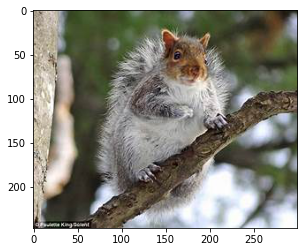

In [ ]:
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/kaggle_dataset/raw-img/"+folder+"/"+sample)
plt.imshow(image)

In [ ]:
#initializing empty train df
train_df = pd.DataFrame(columns=['filename', 'category'])

#collecting 500 samples from each of 10 categories
i = 0
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])

print(train_df.head())
train_df = train_df.reset_index(drop=True) # reset index of a Data Frame
train_df

                                            filename category
0  /content/drive/MyDrive/kaggle_dataset/raw-img/...        0
1  /content/drive/MyDrive/kaggle_dataset/raw-img/...        0
2  /content/drive/MyDrive/kaggle_dataset/raw-img/...        0
3  /content/drive/MyDrive/kaggle_dataset/raw-img/...        0
4  /content/drive/MyDrive/kaggle_dataset/raw-img/...        0


,filename,category
0,/content/drive/MyDrive/kaggle_dataset/raw-img/...,0
1,/content/drive/MyDrive/kaggle_dataset/raw-img/...,0
2,/content/drive/MyDrive/kaggle_dataset/raw-img/...,0
3,/content/drive/MyDrive/kaggle_dataset/raw-img/...,0
4,/content/drive/MyDrive/kaggle_dataset/raw-img/...,0
...,...,...
4995,/content/drive/MyDrive/kaggle_dataset/raw-img/...,9
4996,/content/drive/MyDrive/kaggle_dataset/raw-img/...,9
4997,/content/drive/MyDrive/kaggle_dataset/raw-img/...,9
4998,/content/drive/MyDrive/kaggle_dataset/raw-img/...,9


Shuffling input and target for optimum training

In [ ]:
y = train_df['category']
x = train_df['filename']

x, y = shuffle(x, y, random_state=8)

Function for Resizing and Reshaping the input images

In [ ]:
def centering_image(img):
    size = [256,256]
    
#shape:(h×w×t)taking the first2 elements(h,w) and unpacking them appropriately 
    img_size = img.shape[:2]
    
    # extracting the excess space for centering.
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    
#creating centered image by taking a 0-matrix and then re-assigning intensities
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img 

    return resized

 Image Resizing and converting them to array

In [ ]:
images = []

with tqdm(total=len(train_df)) as k:  
    for i, file_path in enumerate(train_df.filename.values):
        
        #color order is changed
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #output 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        k.update(1)

images = np.array(images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/5000 [00:00<?, ?it/s]


Re-Shuffling processed train data and converting to array

In [ ]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

Train val split

In [ ]:
#train_test split
val_size = int(round(0.8*len(y)))
x_train = x[:val_size]
y_train = y[:val_size]
x_val = x[val_size:]
y_val = y[val_size:]

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_val.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_val.shape)


y_train = to_categorical(y_train) 
#y_val = to_categorical(y_val)

#dividing each intensity in array by 225 ( 225 is max intensity in RGB)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255 
x_val /= 255

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_val.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_val.shape)
print('image Shape:', x_train[0].shape)

x_train Shape: (4000, 224, 224, 3) 	 x_test Shape: (1000, 224, 224, 3)
y_train Shape:  (4000,) 	 y_test Shape: (1000,)
x_train Shape: (4000, 224, 224, 3) 	 x_test Shape: (1000, 224, 224, 3)
y_train Shape:  (4000, 10) 	 y_test Shape: (1000,)
image Shape: (224, 224, 3)


 Data Augmentation

In [ ]:
# ImageDataGenerator for data augmentation 

train_data_gen = ImageDataGenerator(rotation_range=45, 
                                    width_shift_range=0.1,
                                    height_shift_range=0.1, 
                                    horizontal_flip=True)
train_data_gen.fit(x_train) 

 Preprocessing test data

In [ ]:
test_images = []
test_df = pd.DataFrame(columns=['filename'])
actual_pred=pd.DataFrame(columns=['Category'])
for i in range(10):
    test_df = test_df.append(df[df.category == i].iloc[500:502,:1])
    actual_pred=actual_pred.append(df[df.category == i].iloc[500:502,1:])

    test_df = test_df.reset_index(drop=True)
    actual_pred = actual_pred.reset_index(drop=True)
with tqdm(total=len(test_df)) as k:  
    for i, file_path in enumerate(test_df.filename.values):
        
        #color order is changed
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #output 224*224px 
        img = img[16:240, 16:240]
        test_images.append(img)
        k.update(1)
test_images = np.array(test_images).reshape(-1,224,224,3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/20 [00:00<?, ?it/s]

 Renaming Animals (helpful in viewing predictions)

In [ ]:
animal_names = [] 
for i in range(10):
    path = train_df[train_df.category == i].values[1]
    if path[0].split('/')[-2] == 'scoiattolo':
        animal_names.append('squirrel')
    elif path[0].split('/')[-2] == 'cavallo':
        animal_names.append('horse')
    elif path[0].split('/')[-2] == 'farfalla':
        animal_names.append('butterfly')
    elif path[0].split('/')[-2] == 'mucca':
        animal_names.append('cow')
    elif path[0].split('/')[-2] == 'gatto':
        animal_names.append('cat')
    elif path[0].split('/')[-2] == 'pecora':
        animal_names.append('sheep')
    elif path[0].split('/')[-2] == 'gallina':
        animal_names.append('chicken')
    elif path[0].split('/')[-2] == 'elefante':
        animal_names.append('elephant')
    elif path[0].split('/')[-2] == 'ragno':
        animal_names.append('spider')
    elif path[0].split('/')[-2] == 'cane':
        animal_names.append('dog')

Creating a Convolutional Neural Network using VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
rows,cols,channel = 224, 224, 3

epochs = 5
learning_rate = 0.0001
decay_rate = learning_rate / epochs
momentum =0.9
sgd = tf.keras.optimizers.SGD(lr=learning_rate, momentum=momentum,decay=decay_rate, nesterov=False)

base_model1 = tf.keras.applications.VGG16(weights='imagenet', include_top=False,input_shape=(224,224,3))
model1 = Sequential()
model1.add(Flatten(input_shape= base_model1.output_shape[1:]))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(10, activation='softmax'))

vgg16_model = Model(inputs=base_model1.input,
                        outputs=model1(base_model1.output))

vgg16_model.compile(loss='binary_crossentropy',
                        optimizer=sgd,metrics=['accuracy'])

vgg16_model.summary()


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
batch_size = 16
epochs = 5  
neural_ntwk1 = vgg16_model.fit(train_data_gen.flow(x_train, y_train,
                                        batch_size=batch_size),
                    steps_per_epoch= x_train.shape[0] // batch_size,
                    epochs=epochs,validation_data=(x_val, y_val),
                    callbacks=[ModelCheckpoint('VGG16-transferlearning.model',
                               monitor='val_acc')])

Epoch 1/5
250/250 [==============================] - 7760s 31s/step - loss: 0.3233 - accuracy: 0.1427 - val_loss: 0.3134 - val_accuracy: 0.2010
Epoch 2/5
250/250 [==============================] - 7032s 28s/step - loss: 0.3060 - accuracy: 0.2605 - val_loss: 0.2909 - val_accuracy: 0.3560
Epoch 3/5
250/250 [==============================] - 7312s 29s/step - loss: 0.2818 - accuracy: 0.3823 - val_loss: 0.2555 - val_accuracy: 0.4770
Epoch 4/5
250/250 [==============================] - 7654s 31s/step - loss: 0.2506 - accuracy: 0.4683 - val_loss: 0.2171 - val_accuracy: 0.5650
Epoch 5/5
250/250 [==============================] - 7812s 31s/step - loss: 0.2189 - accuracy: 0.5667 - val_loss: 0.1863 - val_accuracy: 0.6540


In [ ]:
print("VGG16: Epochs={0:d}, Train accuracy={1:.5f}, Val accuracy={2:.5f}".format(epochs,neural_ntwk1.history['accuracy'][epochs-1],neural_ntwk1.history['val_accuracy'][epochs-1]))

VGG16: Epochs=5, Train accuracy=0.56675, Val accuracy=0.65400


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  fig.canvas.print_figure(bytes_io, **kw)


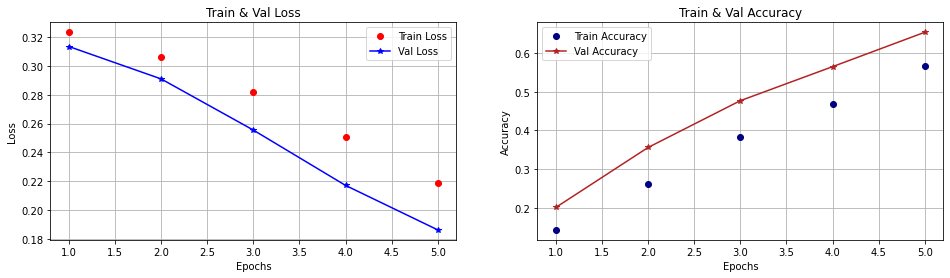

In [ ]:
def show_plots(neural_ntwk):
    loss_vals = neural_ntwk['loss']
    val_loss_vals = neural_ntwk['val_loss']
    epochs = range(1, len(neural_ntwk['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    ax[0].plot(epochs, loss_vals, color='R',marker='o',
               linestyle=' ', label='Train Loss')
    ax[0].plot(epochs, val_loss_vals, color='B',
               marker='*', label='Val Loss')
    ax[0].set(title='Train & Val Loss', xlabel='Epochs',ylabel='Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = neural_ntwk['accuracy']
    val_acc_vals = neural_ntwk['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o',
               ls=' ', label='Train Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick',
               marker='*', label='Val Accuracy')
    ax[1].set(title='Train & Val Accuracy',xlabel='Epochs',ylabel='Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
show_plots(neural_ntwk1.history)


Model Evaluation on Testing Set

In [ ]:
score = vgg16_model.evaluate(x_val, y_val, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1862543225288391
Test accuracy: 0.6539999842643738


Confusion Metrics

NameError: ignored

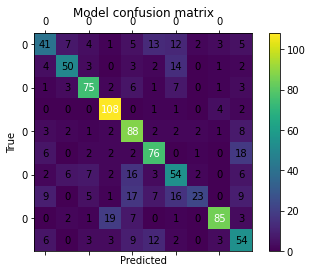

In [ ]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score

pred = vgg16_model.predict(x_val)
predictions = argmax(pred, axis=1) # return to label

cm = confusion_matrix(y_val, predictions)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Model confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + categories)
ax.set_yticklabels([''] + categories)

thresh = cm.max() / 2.
for i in range(10):
    for j in range(10):
        ax.text(i, j, cm[j, i], va='center', ha='center', color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted')
plt.ylabel('True')
#plt.show()
plot_confusion_matrix(confusion_matrix, 
                      ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells','cat','dog','sheep','cow'],
                     normalize=True)

Predicting Categories for Test Data


In [ ]:
test_prediction1 = vgg16_model.predict(test_images)

 Viewing Predictions

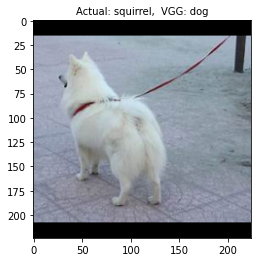

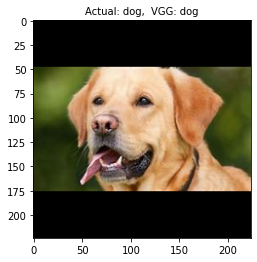

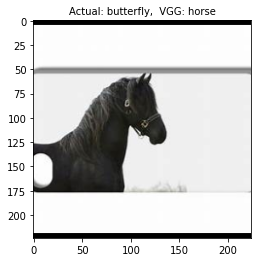

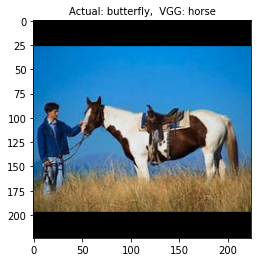

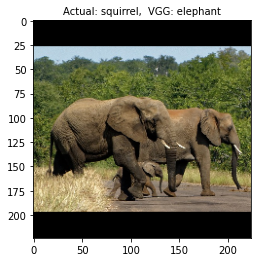

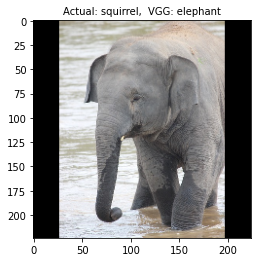

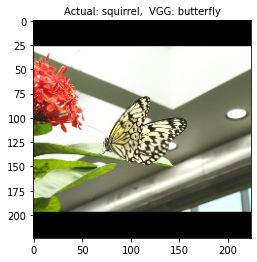

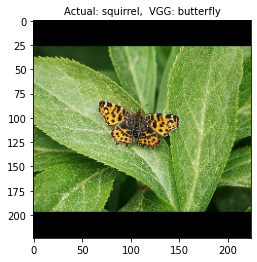

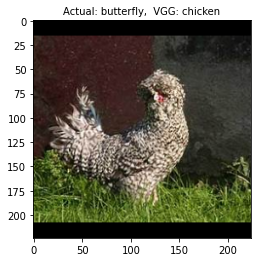

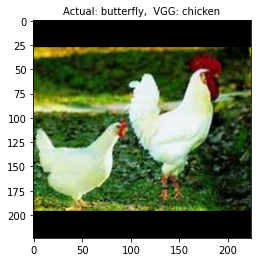

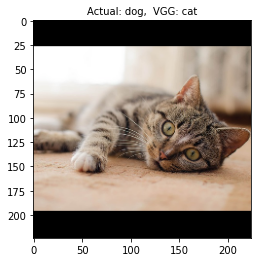

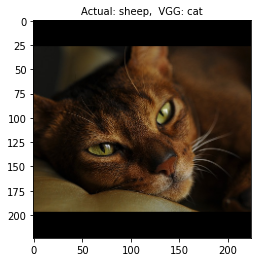

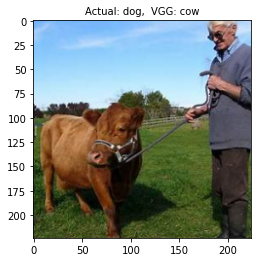

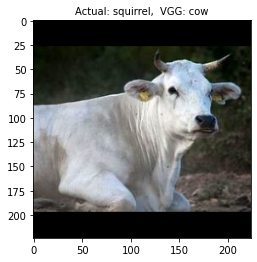

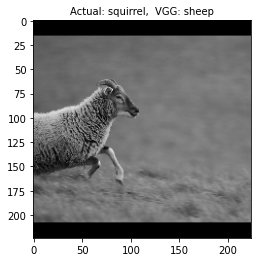

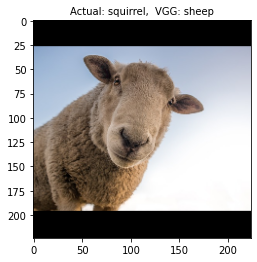

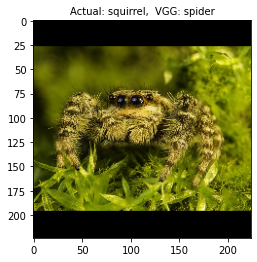

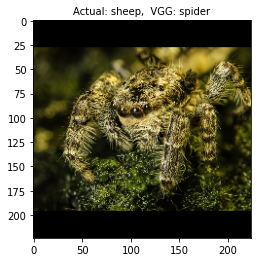

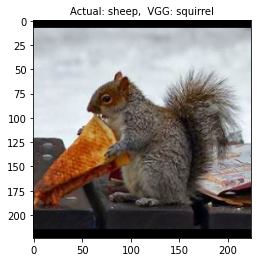

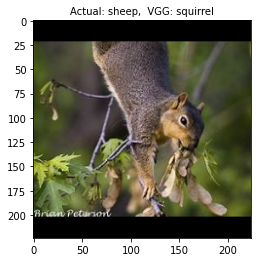

In [ ]:
actual_pred['category']=actual_pred['category'].astype('int')
for i in range(20):
    predict1= test_prediction1[i].argmax()
    actual=actual_pred['category'][i]
    plt.imshow(test_images[i])
    plt.title("Actual: {1},  VGG: {0}".format((animal_names[actual]),(animal_names[predict1])), fontsize=10)
    plt.show()